# 양서강(개구리목, 도롱뇽목, 무족영원목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [3]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220818_2215]CREATED 양서강의 개구리, 도롱뇽, 무족영원목에 속하는 9종 선정
species = ['Lithobates catesbeianus', 'Bufo gargarizans', 'Dryophytes japonicus', 
           'Hynobius leechii', 'Dicamptodon ensatus', 'Siren intermedia', 
           'Ichthyophis bannanicus', 'Boulengerula changamwensis', 'Caecilia tentaculata']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating EF525863.1.fasta...
## creating EF525862.1.fasta...
## creating EF525861.1.fasta...
## creating EF525860.1.fasta...
## creating EF525859.1.fasta...
## creating EF525858.1.fasta...
## creating EF525857.1.fasta...
## creating EF525856.1.fasta...
## creating EF525855.1.fasta...
## creating EF525854.1.fasta...
## creating EF525853.1.fasta...
## creating EF525852.1.fasta...
## creating EF525851.1.fasta...
## creating EF525848.1.fasta...
## creating MH034267.1.fasta...
## creating MH034266.1.fasta...
## creating KY587197.1.fasta...
## creating KT388393.1.fasta...
## creating KT388392.1.fasta...
## creating KT388391.1.fasta...
## creating JQ798860.1.fasta...
## creating JQ798859.1.fasta...
## creating JQ798858.1.fasta...
## creating JQ844537.1.fasta...
## creating JQ844536.1.fasta...
## creating JQ844535.1.fasta...
## creating AF314016.1.fasta...
## creating KF665641.1.fasta...
## creating KF665586.1.fasta...
## creating JQ798832.1.fasta...
## creating JQ798831.1.fasta...
## creat

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [2]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_amphibia_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
k_gc += 300
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_amphibia_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    if(index == 0):
        gc_rates.append(GC(record.seq))
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

680


### 기존 데이터 슬라이싱 후 3-mer 적용

In [3]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_amphibia_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [144]:
df.groupby('target').count()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents
target,,,,,,,,,,,,,,,,,,,,,
Boulengerula changamwensis,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Bufo gargarizans,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
Caecilia tentaculata,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Dicamptodon ensatus,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Dryophytes japonicus,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
Hynobius leechii,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
Ichthyophis bannanicus,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
Lithobates catesbeianus,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Siren intermedia,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [145]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Lithobates catesbeianus', 'Hynobius leechii', 'Siren intermedia',
       'Dryophytes japonicus', 'Ichthyophis bannanicus',
       'Bufo gargarizans', 'Caecilia tentaculata', 'Dicamptodon ensatus',
       'Boulengerula changamwensis'], dtype=object)

In [4]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
 """
pd.reset_option('^display.', silent=True)

df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,21,9,20,9,8,11,10,4,10,4,...,10,5,14,18,26,8,14,15,44.852941,Lithobates catesbeianus
1,32,14,16,21,10,9,11,3,8,6,...,10,1,14,15,33,6,17,31,37.058824,Hynobius leechii
2,26,13,15,24,11,9,11,5,10,4,...,13,1,7,18,32,8,15,32,35.147059,Siren intermedia
3,6,4,12,13,4,7,14,10,15,3,...,7,8,14,19,20,7,19,22,44.901065,Lithobates catesbeianus
4,6,4,12,13,4,7,14,10,15,3,...,7,8,14,19,20,7,19,22,44.748858,Lithobates catesbeianus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,13,13,4,7,14,10,15,3,...,7,8,14,20,17,7,19,21,45.592705,Lithobates catesbeianus
114,7,3,12,18,2,8,12,5,11,2,...,16,5,9,17,14,10,19,23,44.387755,Dryophytes japonicus
115,6,4,10,13,4,7,12,8,13,3,...,7,6,14,16,15,7,15,20,45.408163,Lithobates catesbeianus
116,6,4,10,13,4,7,12,8,13,3,...,7,6,14,16,15,7,15,20,45.408163,Lithobates catesbeianus


In [9]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[7 5 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 6 6 5 1 1 1 5 5 5 1 1 1 7 7 7 4 5 5 1 1 1 4 4 4 4 7 7 7 4 4 4 4 4 4 4 4 4
 4 1 1 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 2 2 3 3 3 8 3 3 0 4 4 4 4 4 4 4 4 4 4
 4 4 7 4 7 7 8]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,nmf_x,nmf_y
0,21,9,20,9,8,11,10,4,10,4,...,14,18,26,8,14,15,44.852941,7,3.634884,0.262655
1,32,14,16,21,10,9,11,3,8,6,...,14,15,33,6,17,31,37.058824,5,2.282908,2.689504
2,26,13,15,24,11,9,11,5,10,4,...,7,18,32,8,15,32,35.147059,8,1.813113,3.539090
3,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,44.901065,7,3.553577,0.391236
4,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,44.748858,7,3.502736,0.469207


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [11]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,nmf_x,nmf_y
0,21,9,20,9,8,11,10,4,10,4,...,14,18,26,8,14,15,0.692308,7,3.634884,0.262655
1,32,14,16,21,10,9,11,3,8,6,...,14,15,33,6,17,31,0.136364,5,2.282908,2.689504
2,26,13,15,24,11,9,11,5,10,4,...,7,18,32,8,15,32,0.000000,8,1.813113,3.539090
3,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,0.695740,7,3.553577,0.391236
4,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,0.684884,7,3.502736,0.469207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,13,13,4,7,14,10,15,3,...,14,20,17,7,19,21,0.745074,7,3.729286,0.077908
114,7,3,12,18,2,8,12,5,11,2,...,9,17,14,10,19,23,0.659127,4,2.591422,1.482473
115,6,4,10,13,4,7,12,8,13,3,...,14,16,15,7,15,20,0.731911,7,3.447076,0.026819
116,6,4,10,13,4,7,12,8,13,3,...,14,16,15,7,15,20,0.731911,7,3.447076,0.026819


## SVM 모델 생성

In [150]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df.loc[:, 'AAA':'GC-contents']
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/kimjoonsu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 1, 'gamma': 1}
0.9157894736842105
오차 행렬
[[4 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 6 0 0 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 6]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


## KMeans 모델의 최적 K값 구하기

### Elbow Method

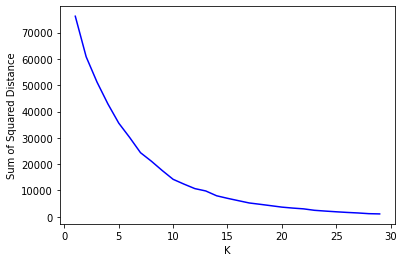

In [151]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [152]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.loc[:,:'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:,:'GC-contents'], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,:'GC-contents'], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.241
군집 별 실루엣 계수 평균: 
cluster
0    0.313329
1    0.195672
Name: sil_sam, dtype: float64
score: 0.059
---------------
전체 실루엣 계수 평균: 0.252
군집 별 실루엣 계수 평균: 
cluster
0    0.090577
1    0.222462
2    0.512453
Name: sil_sam, dtype: float64
score: 0.150
---------------
전체 실루엣 계수 평균: 0.344
군집 별 실루엣 계수 평균: 
cluster
0    0.345369
1    0.616209
2    0.074799
3    0.932194
Name: sil_sam, dtype: float64
score: 0.283
---------------
전체 실루엣 계수 평균: 0.397
군집 별 실루엣 계수 평균: 
cluster
0    0.613866
1    0.336027
2    0.127039
3    0.932194
4    0.367785
Name: sil_sam, dtype: float64
score: 0.222
---------------
전체 실루엣 계수 평균: 0.460
군집 별 실루엣 계수 평균: 
cluster
0    0.584525
1    0.188508
2    0.157691
3    0.922153
4    0.446930
5    0.717403
Name: sil_sam, dtype: float64
score: 0.238
---------------
전체 실루엣 계수 평균: 0.510
군집 별 실루엣 계수 평균: 
cluster
0    0.922153
1    0.434804
2    0.272666
3    0.584525
4    0.542146
5    0.717403
6    0.182488
Name: sil_sam, dtype: float64
score: 0.195
--------------

## K-means 모델 생성

In [153]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [154]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.8342]
평균 검증 정확도: 0.8342


* 검증 데이터셋 생성

In [155]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.8535, 0.8462, 0.886, 0.8436, 0.8073]
평균 검증 정확도: 0.8473


## 차원 축소 및 데이터 분포 확인

### 기존 차원에서의 클러스터링 정확도

In [156]:
km = KMeans(n_clusters = 15, max_iter = 1000)
km.fit(df.loc[:, 'AAA':'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.7406070586147213

In [157]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
target,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,6,0,0,5,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
4,0,0,12,0,0,2,15,0,0,0,0,0,0,0,0
5,0,0,0,22,0,0,0,0,3,0,0,0,0,0,1
6,0,8,0,0,0,0,0,0,0,0,0,0,0,6,0
7,9,0,0,0,14,3,0,0,0,1,0,0,0,0,0
8,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1


### PCA 차원축소 사용했을 때 클러스터링 정확도

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.loc[:, :'GC-contents'])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,21,9,20,9,8,11,10,4,10,4,...,18,26,8,14,15,0.692308,7,9,-15.338890,10.215701
1,32,14,16,21,10,9,11,3,8,6,...,15,33,6,17,31,0.136364,5,14,6.328838,4.784182
2,26,13,15,24,11,9,11,5,10,4,...,18,32,8,15,32,0.000000,8,14,14.089505,0.489540
3,6,4,12,13,4,7,14,10,15,3,...,19,20,7,19,22,0.695740,7,4,-14.924431,6.279324
4,6,4,12,13,4,7,14,10,15,3,...,19,20,7,19,22,0.684884,7,4,-14.180808,6.100349


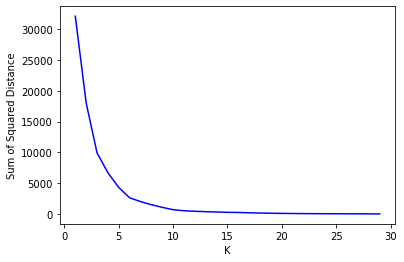

In [159]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['pca_x', 'pca_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [160]:
km = KMeans(n_clusters = 5, max_iter = 1000)
km.fit(df[['pca_x', 'pca_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8002231059702324

In [161]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4
target,,,,,
0,0,0,0,0,1
1,5,0,6,0,0
2,0,0,2,0,0
3,0,0,0,1,4
4,2,27,0,0,0
5,1,0,0,22,3
6,12,0,2,0,0
7,3,9,15,0,0
8,0,0,0,2,1


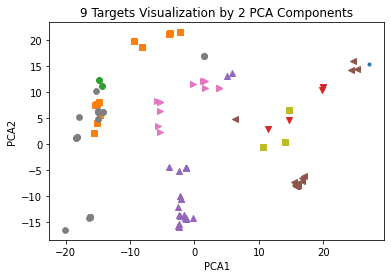

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

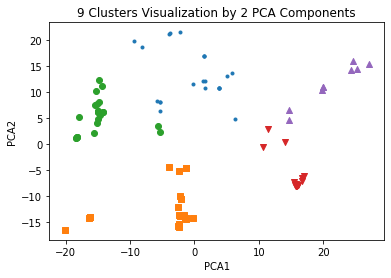

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

### LDA 차원축소 사용했을 때

In [164]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'GC-contents'], df['target'])
ma_lda = lda.transform(df.loc[:, :'GC-contents'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(118, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y,lda_x,lda_y
0,21,9,20,9,8,11,10,4,10,4,...,8,14,15,0.692308,7,2,-15.338890,10.215701,-145.966459,-80.814925
1,32,14,16,21,10,9,11,3,8,6,...,6,17,31,0.136364,5,0,6.328838,4.784182,299.389259,-28.688387
2,26,13,15,24,11,9,11,5,10,4,...,8,15,32,0.000000,8,3,14.089505,0.489540,9.687894,106.250020
3,6,4,12,13,4,7,14,10,15,3,...,7,19,22,0.695740,7,2,-14.924431,6.279324,-143.788823,-79.650410
4,6,4,12,13,4,7,14,10,15,3,...,7,19,22,0.684884,7,2,-14.180808,6.100349,-145.831537,-80.977065


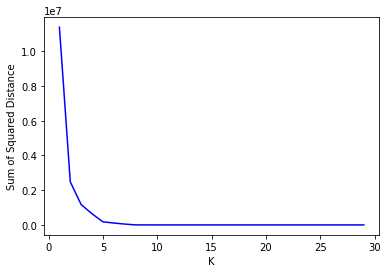

In [165]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['lda_x', 'lda_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [166]:
km = KMeans(n_clusters = 9, max_iter = 1000)
km.fit(df[['lda_x', 'lda_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

1.0

In [167]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8
target,,,,,,,,,
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,11,0,0,0
2,0,0,0,0,0,0,0,0,2
3,0,0,0,0,5,0,0,0,0
4,0,0,29,0,0,0,0,0,0
5,0,26,0,0,0,0,0,0,0
6,0,0,0,14,0,0,0,0,0
7,27,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,3,0,0


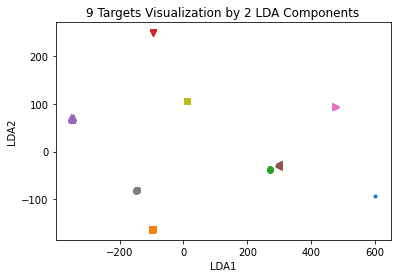

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'lda_x'], y = df.loc[j, 'lda_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

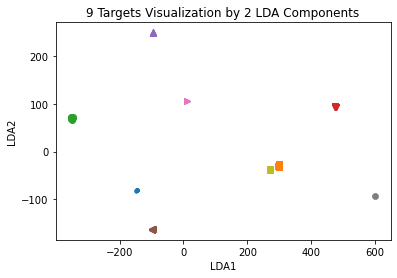

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'lda_x'], y = df.loc[j, 'lda_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

### t-sne 차원축소 사용했을 때

In [170]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:, :'GC-contents'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTT,GC-contents,target,cluster,pca_x,pca_y,lda_x,lda_y,tsne_x,tsne_y
0,21,9,20,9,8,11,10,4,10,4,...,15,0.692308,7,0,-15.338890,10.215701,-145.966459,-80.814925,4.397483,6.918957
1,32,14,16,21,10,9,11,3,8,6,...,31,0.136364,5,1,6.328838,4.784182,299.389259,-28.688387,-2.183763,3.516228
2,26,13,15,24,11,9,11,5,10,4,...,32,0.000000,8,6,14.089505,0.489540,9.687894,106.250020,-2.204977,3.506216
3,6,4,12,13,4,7,14,10,15,3,...,22,0.695740,7,0,-14.924431,6.279324,-143.788823,-79.650410,4.816785,4.961333
4,6,4,12,13,4,7,14,10,15,3,...,22,0.684884,7,0,-14.180808,6.100349,-145.831537,-80.977065,4.588758,4.737022


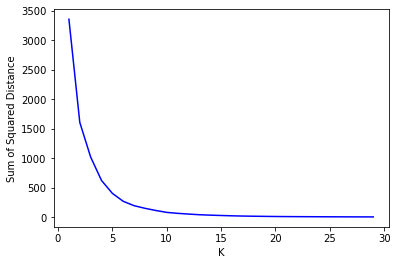

In [171]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [172]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

top_sil = {}
top_sco = {}

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    top_sil[k] = sil_tot
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    top_sco[k] = score_k
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.478
군집 별 실루엣 계수 평균: 
cluster
0    0.562522
1    0.426471
Name: sil_sam, dtype: float32
score: 0.068
---------------
전체 실루엣 계수 평균: 0.484
군집 별 실루엣 계수 평균: 
cluster
0    0.498106
1    0.527391
2    0.426101
Name: sil_sam, dtype: float32
score: 0.038
---------------
전체 실루엣 계수 평균: 0.550
군집 별 실루엣 계수 평균: 
cluster
0    0.469915
1    0.636149
2    0.633287
3    0.464483
Name: sil_sam, dtype: float32
score: 0.084
---------------
전체 실루엣 계수 평균: 0.607
군집 별 실루엣 계수 평균: 
cluster
0    0.661011
1    0.719308
2    0.595887
3    0.546706
4    0.449433
Name: sil_sam, dtype: float32
score: 0.079
---------------
전체 실루엣 계수 평균: 0.654
군집 별 실루엣 계수 평균: 
cluster
0    0.546706
1    0.449809
2    0.719654
3    0.837148
4    0.957187
5    0.625096
Name: sil_sam, dtype: float32
score: 0.149
---------------
전체 실루엣 계수 평균: 0.700
군집 별 실루엣 계수 평균: 
cluster
0    0.546706
1    0.705020
2    0.584720
3    0.810477
4    0.625096
5    0.821984
6    0.941570
Name: sil_sam, dtype: float32
score: 0.117
--------------

In [173]:
km = KMeans(n_clusters = 9, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.8755136590385633

In [174]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8
target,,,,,,,,,
0,0,0,0,0,0,1,0,0,0
1,0,0,0,5,0,0,0,6,0
2,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,5
4,0,0,27,0,0,2,0,0,0
5,23,0,0,0,0,3,0,0,0
6,0,0,0,0,14,0,0,0,0
7,0,14,0,3,0,0,9,1,0
8,3,0,0,0,0,0,0,0,0


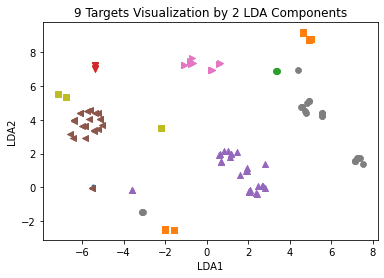

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

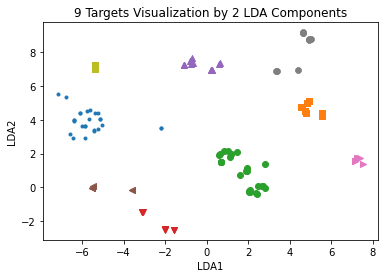

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

In [201]:
km2 = KMeans(n_clusters = 9, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.8755136590385633

### NMF 차원축소 사용했을 때

In [12]:
from sklearn.decomposition import NMF

nmf = NMF(n_components = 2)
nmf_seq = nmf.fit_transform(df.loc[:, :'GC-contents'])

df['nmf_x'] = nmf_seq[:, 0]
df['nmf_y'] = nmf_seq[:, 1]

df

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,nmf_x,nmf_y
0,21,9,20,9,8,11,10,4,10,4,...,14,18,26,8,14,15,0.692308,7,1.372994,3.408467
1,32,14,16,21,10,9,11,3,8,6,...,14,15,33,6,17,31,0.136364,5,2.698945,1.662278
2,26,13,15,24,11,9,11,5,10,4,...,7,18,32,8,15,32,0.000000,8,3.167835,1.024170
3,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,0.695740,7,1.456843,3.260689
4,6,4,12,13,4,7,14,10,15,3,...,14,19,20,7,19,22,0.684884,7,1.497528,3.190841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6,4,13,13,4,7,14,10,15,3,...,14,20,17,7,19,21,0.745074,7,1.288429,3.493607
114,7,3,12,18,2,8,12,5,11,2,...,9,17,14,10,19,23,0.659127,4,1.972292,1.853962
115,6,4,10,13,4,7,12,8,13,3,...,14,16,15,7,15,20,0.731911,7,1.165953,3.117431
116,6,4,10,13,4,7,12,8,13,3,...,14,16,15,7,15,20,0.731911,7,1.165953,3.117431


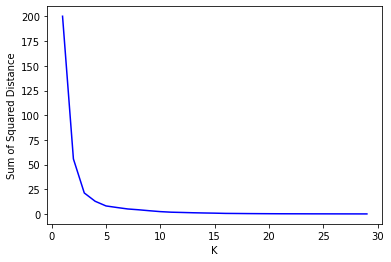

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['nmf_x', 'nmf_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

top_sil = {}
top_sco = {}

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df[['nmf_x', 'nmf_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['nmf_x', 'nmf_y']], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df[['nmf_x', 'nmf_y']], df['cluster'])
    top_sil[k] = sil_tot
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    top_sco[k] = score_k
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.478
군집 별 실루엣 계수 평균: 
cluster
0    0.562522
1    0.426471
Name: sil_sam, dtype: float32
score: 0.068
---------------
전체 실루엣 계수 평균: 0.484
군집 별 실루엣 계수 평균: 
cluster
0    0.498106
1    0.527391
2    0.426101
Name: sil_sam, dtype: float32
score: 0.038
---------------
전체 실루엣 계수 평균: 0.550
군집 별 실루엣 계수 평균: 
cluster
0    0.469915
1    0.636149
2    0.633287
3    0.464483
Name: sil_sam, dtype: float32
score: 0.084
---------------
전체 실루엣 계수 평균: 0.607
군집 별 실루엣 계수 평균: 
cluster
0    0.661011
1    0.719308
2    0.595887
3    0.546706
4    0.449433
Name: sil_sam, dtype: float32
score: 0.079
---------------
전체 실루엣 계수 평균: 0.654
군집 별 실루엣 계수 평균: 
cluster
0    0.546706
1    0.449809
2    0.719654
3    0.837148
4    0.957187
5    0.625096
Name: sil_sam, dtype: float32
score: 0.149
---------------
전체 실루엣 계수 평균: 0.700
군집 별 실루엣 계수 평균: 
cluster
0    0.546706
1    0.705020
2    0.584720
3    0.810477
4    0.625096
5    0.821984
6    0.941570
Name: sil_sam, dtype: float32
score: 0.117
--------------

In [15]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

In [17]:
km = KMeans(n_clusters = 9, max_iter = 1000)
km.fit(df[['nmf_x', 'nmf_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.739205707021799

In [18]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8
target,,,,,,,,,
0,0,0,0,0,0,0,0,0,1
1,0,4,0,7,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0
3,1,0,0,0,0,0,0,1,3
4,0,0,10,0,0,17,2,0,0
5,22,0,0,0,0,0,1,0,3
6,0,4,0,0,0,6,4,0,0
7,0,0,0,15,9,3,0,0,0
8,0,0,0,0,0,0,0,3,0


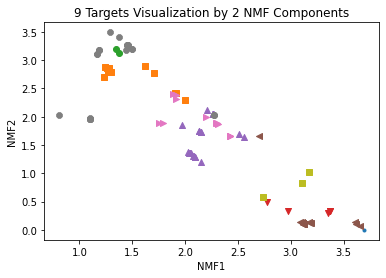

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'nmf_x'], y = df.loc[j, 'nmf_y'], marker = i)

plt.xlabel('NMF1')
plt.ylabel('NMF2')
plt.title('9 Targets Visualization by 2 NMF Components')
plt.show()

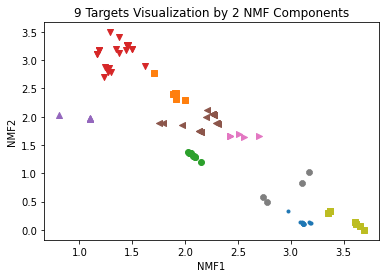

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'nmf_x'], y = df.loc[j, 'nmf_y'], marker = i)

plt.xlabel('NMF1')
plt.ylabel('NMF2')
plt.title('9 Targets Visualization by 2 NMF Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 9, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.8755136590385633